In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run 'req_analysis/neptune-util.py'
%env NEPTUNE_CLUSTER_ENDPOINT=ec2-18-224-170-154.us-east-2.compute.amazonaws.com
%env NEPTUNE_CLUSTER_PORT=8182
g = neptune.graphTraversal()

env: NEPTUNE_CLUSTER_ENDPOINT=ec2-18-224-170-154.us-east-2.compute.amazonaws.com
env: NEPTUNE_CLUSTER_PORT=8182
gremlin: ws://ec2-18-224-170-154.us-east-2.compute.amazonaws.com:8182/gremlin


In [3]:
import scipy
import time

import matplotlib.pyplot as plt
import networkx as nx

from req_analysis import Requirement

In [4]:
from SPARQLWrapper import SPARQLWrapper, JSON, POST, DIGEST, URLENCODED

sparql = SPARQLWrapper("http://ec2-18-224-170-154.us-east-2.compute.amazonaws.com:3001/sparql")

In [5]:
queryString = """prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix owl: <http://www.w3.org/2002/07/owl#>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>
prefix xml: <http://www.w3.org/XML/1998/namespace/>
prefix mms-ontology: <https://opencae.jpl.nasa.gov/mms/rdf/ontology/>
prefix mms-graph: <https://opencae.jpl.nasa.gov/mms/rdf/graph/>
prefix mms-property: <https://opencae.jpl.nasa.gov/mms/rdf/property/>
prefix mms-class: <https://opencae.jpl.nasa.gov/mms/rdf/class/>
prefix mms-element: <https://opencae.jpl.nasa.gov/mms/rdf/element/>
prefix mms-artifact: <https://opencae.jpl.nasa.gov/mms/rdf/artifact/>
prefix mms-index: <https://opencae.jpl.nasa.gov/mms/rdf/index/>
prefix xmi: <http://www.omg.org/spec/XMI/20131001#>
prefix uml: <http://www.omg.org/spec/UML/20161101#>
prefix uml-model: <https://www.omg.org/spec/UML/20161101/UML.xmi#>
prefix uml-primitives: <https://www.omg.org/spec/UML/20161101/PrimitiveTypes.xmi#>
prefix uml-class: <https://opencae.jpl.nasa.gov/mms/rdf/uml-class/>
prefix uml-property: <https://opencae.jpl.nasa.gov/mms/rdf/uml-property/>

select * from mms-graph:data.tmt {
    ?subject ?edge ?str .

    values ?edge {
        mms-property:bodyStringFromComment
        mms-property:valueString
    }
    
    filter(contains(?str, "REQ-") && strlen(?str) > 20)
    # filter(isLiteral(?str) && ?str != "")
    
    values ?subject { mms-element:_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311-slotvalue-0-literalstring }
}
"""

In [6]:
queryElements = """prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix owl: <http://www.w3.org/2002/07/owl#>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>
prefix xml: <http://www.w3.org/XML/1998/namespace/>
prefix mms-ontology: <https://opencae.jpl.nasa.gov/mms/rdf/ontology/>
prefix mms-graph: <https://opencae.jpl.nasa.gov/mms/rdf/graph/>
prefix mms-property: <https://opencae.jpl.nasa.gov/mms/rdf/property/>
prefix mms-class: <https://opencae.jpl.nasa.gov/mms/rdf/class/>
prefix mms-element: <https://opencae.jpl.nasa.gov/mms/rdf/element/>
prefix mms-artifact: <https://opencae.jpl.nasa.gov/mms/rdf/artifact/>
prefix mms-index: <https://opencae.jpl.nasa.gov/mms/rdf/index/>
prefix xmi: <http://www.omg.org/spec/XMI/20131001#>
prefix uml: <http://www.omg.org/spec/UML/20161101#>
prefix uml-model: <https://www.omg.org/spec/UML/20161101/UML.xmi#>
prefix uml-primitives: <https://www.omg.org/spec/UML/20161101/PrimitiveTypes.xmi#>
prefix uml-class: <https://opencae.jpl.nasa.gov/mms/rdf/uml-class/>
prefix uml-property: <https://opencae.jpl.nasa.gov/mms/rdf/uml-property/>

select * from mms-graph:data.tmt {
    ?element a/rdfs:subClassOf* uml-class:Class
    {
        ?element rdfs:label ?label 
    } union {
        ?element mms-property:name ?label
    }
    
    filter(isLiteral(?label) && ?label != "")
}
"""

## Load model elements in memory

In [7]:
sparql.setQuery(queryElements)

sparql.setReturnFormat(JSON)
el_results = sparql.query().convert()

In [8]:
model_elements = []
for result in el_results["results"]["bindings"]:
    model_elements.append(dict(uri=result['element']['value'], name=result['label']['value']))

## Load text element(s) of interest

In [9]:
sparql.setQuery(queryString)

sparql.setReturnFormat(JSON)
results = sparql.query().convert()

## Matching

In [10]:
time1 = time.time()
for result in results["results"]["bindings"]:
#     if str.startswith(result["str"]["value"], "<html>"):
    req_object = Requirement(result["subject"]["value"], result["str"]["value"])
    matches, c = req_object.match_req_tokens(model_elements, 0.0030)
    if len(matches)>3:
        print('Req ID: ', result["subject"]["value"], '\nReq text:' , (result["str"]["value"]))
        print(matches, '\n___________')
        print(c, 'comparaisons')
        print('Time: ', time.time()-time1)
        break

Req ID:  https://opencae.jpl.nasa.gov/mms/rdf/element/_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311-slotvalue-0-literalstring 
Req text: <html><body>
<span xmlns="http://www.w3.org/1999/xhtml"><strong>[REQ-1-OAD-0185]</strong> The Observatory Safety system decomposition element is defined as follows:<br/>Associated WBS element(s): TMT.TEL.CONT.OSS<br/>The Observatory Safety System (OSS) contributes to the enforcement of safe conditions throughout the summit facility by continuously monitoring the state of connected equipment, systems and sensors and taking appropriate action as soon as an unsafe condition is detected. It is independent from and supplementary to any safety systems and functionality that is contained within individual subsystems. Based on one or more Programmable Logic Controllers (PLCs), it will interface with connected subsystems via a dedicated safety rated fieldbus based on EtherNet/IP; monitor interlock requests an

In [11]:
g = neptune.graphTraversal()
req_object.init_match_subgraph(g)

gremlin: ws://ec2-18-224-170-154.us-east-2.compute.amazonaws.com:8182/gremlin
0 1
{'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_4663af6e-6265-438d-87b8-74e1550518bf__905_643f5aef-34e6-4137-8c0f-d1cf4d9a9e7d', 'name': 'Observatory Safety System'} {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_f1d0357_1462834114886_542515_148655', 'name': 'Observatory Safety Systems'}
FAILURE in  7.118938207626343 s:  
_________
0 2
{'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_4663af6e-6265-438d-87b8-74e1550518bf__905_643f5aef-34e6-4137-8c0f-d1cf4d9a9e7d', 'name': 'Observatory Safety System'} {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_5_3_e64033a_1517512028128_54129_21726', 'name': 'Fault'}
FAILURE in  3.141188859939575 s:  
_________
0 3
{'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_4663af6e-6265-438d-87b8-74e1550518bf__905_643f5aef-34e6-4137-8c0f-d1cf4d9a9e7d', 'name': 'Observatory Safety System'} {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/el

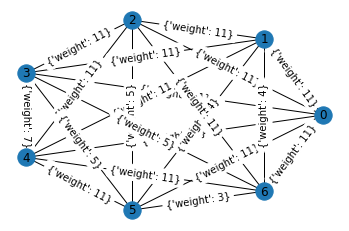

In [12]:
pos = nx.circular_layout(req_object.req_subgraph)
nx.draw_networkx_edge_labels(req_object.req_subgraph, pos)
nx.draw_circular(req_object.req_subgraph, with_labels=True)

In [13]:
req_object.req_subgraph.nodes(data=True)

NodeDataView({0: {'token': {'text': 'Observatory Safety System', 'pos': 'PROPN', 'token_id': 20}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_4663af6e-6265-438d-87b8-74e1550518bf__905_643f5aef-34e6-4137-8c0f-d1cf4d9a9e7d', 'name': 'Observatory Safety System'}, 'score': -0.0}, 1: {'token': {'text': 'Observatory Safety System', 'pos': 'PROPN', 'token_id': 20}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_f1d0357_1462834114886_542515_148655', 'name': 'Observatory Safety Systems'}, 'score': 0.00010746719455381202}, 2: {'token': {'text': 'fault', 'pos': 'NOUN', 'token_id': 113}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_5_3_e64033a_1517512028128_54129_21726', 'name': 'Fault'}, 'score': 4.440892098500625e-17}, 3: {'token': {'text': 'the Data Management System', 'pos': 'PROPN', 'token_id': 129}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_2_876026b_1427661004426_5567

In [14]:
winners = req_object.match_clustering()

for winner in winners.values():
    print('Token: ', winner['token']['text'])
    print('Element: ', winner['model_element']['name'])
    print('URI: ', winner['model_element']['uri'], '\n_________')

Token:  the Data Management System
Element:  Data Management System
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095 
_________
Token:  Executive Software
Element:  Executive Software
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999 
_________
Token:  Observatory Safety System
Element:  Observatory Safety Systems
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_f1d0357_1462834114886_542515_148655 
_________
Token:  fault
Element:  Fault
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_18_5_3_e64033a_1517512028128_54129_21726 
_________


In [15]:
winners

{129: {'token': {'text': 'the Data Management System',
   'pos': 'PROPN',
   'token_id': 129},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095',
   'name': 'Data Management System'},
  'score': 0.0013642900507215298},
 136: {'token': {'text': 'Executive Software',
   'pos': 'PROPN',
   'token_id': 136},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999',
   'name': 'Executive Software'},
  'score': -0.0},
 20: {'token': {'text': 'Observatory Safety System',
   'pos': 'PROPN',
   'token_id': 20},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_f1d0357_1462834114886_542515_148655',
   'name': 'Observatory Safety Systems'},
  'score': 0.00010746719455381202},
 113: {'token': {'text': 'fault', 'pos': 'NOUN', 'token_id': 113},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_5_3_e64033a_1517512028

In [16]:
insert_blocks = """
<{input_uri}> mms-autocref:reference [
   a mms-autocref:Reference ;
   mms-autocref:inputText \"\"\"{input_text}\"\"\" ;
   mms-autocref:match <{match_uri}> ;
   mms-autocref:token [
     a mms-autocref:Token ;
     mms-autocref:tokenStart "{token_position}"^^xsd:integer ;
     mms-autocref:tokenText \"\"\"{token_text}\"\"\" ;
   ] ;
 ] ;
 ."""

In [17]:
insert_query = """prefix mms-autocref: <https://opencae.jpl.nasa.gov/mms/rdf/autocref/>

with <https://opencae.jpl.nasa.gov/mms/rdf/graph/autocref.tmt.test>
insert {{
  {insert_blocks}
}}"""

In [18]:
insert_concat = ""

for winner in winners.values():
    insert_concat += insert_blocks.format(input_uri = req_object.text_uri,
                                  input_text = req_object.text,
                                  match_uri = winner['model_element']['uri'],
                                  token_position = winner['token']['token_id'],
                                  token_text = winner['token']['text'])

# print(insert_concat)
a = insert_concat.replace('"', r'\"')
insert = insert_query.format(insert_blocks=a)
print(insert)

prefix mms-autocref: <https://opencae.jpl.nasa.gov/mms/rdf/autocref/>

with <https://opencae.jpl.nasa.gov/mms/rdf/graph/autocref.tmt.test>
insert {
  
<https://opencae.jpl.nasa.gov/mms/rdf/element/_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311-slotvalue-0-literalstring> mms-autocref:reference [
   a mms-autocref:Reference ;
   mms-autocref:inputText \"\"\"<html><body>
<span xmlns=\"http://www.w3.org/1999/xhtml\"><strong>[REQ-1-OAD-0185]</strong> The Observatory Safety system decomposition element is defined as follows:<br/>Associated WBS element(s): TMT.TEL.CONT.OSS<br/>The Observatory Safety System (OSS) contributes to the enforcement of safe conditions throughout the summit facility by continuously monitoring the state of connected equipment, systems and sensors and taking appropriate action as soon as an unsafe condition is detected. It is independent from and supplementary to any safety systems and functionality that is contained w

In [176]:
sparql.requestMethod = 'urlencoded'

In [177]:
sparql.setMethod(POST)

sparql.setQuery(insert)



results = sparql.query()
print(results.response.read())

QueryBadFormed: QueryBadFormed: a bad request has been sent to the endpoint, probably the sparql query is bad formed. 

Response:
b'{"requestId":"3cb940e1-af0f-b7e9-bc47-4c1ab2054a17","code":"MissingParameterException","detailedMessage":"Missing \'query\' or \'update\' parameter for POST request"}'

# MISCELLANEOUS 

In [44]:
req_object.match_clustering_stop_condition()

[[ 0.  3.  3.  2.]
 [ 2.  6.  5.  3.]
 [ 4.  5.  9.  2.]
 [ 1.  7. 11.  4.]
 [ 8.  9. 11.  6.]]
[[0, 3], [1], [2], [4], [5]]


{117: 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095',
 124: 'https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999',
 141: 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_6_876026b_1478280404909_609058_173008',
 144: 'https://opencae.jpl.nasa.gov/mms/rdf/element/MMS_1456189351681_ad25f82c-607f-4103-83b1-75f605015749'}

In [113]:
D = [[ 0.,  2.,  3. , 2.],
 [ 3. , 6.,  5.,  3.],
 [ 4. , 5.,  9.,  2.],
 [ 1. , 7., 11.,  4.],
 [ 8. , 9., 11.,  6.]]

In [98]:
from paris.utils import select_clustering, select_clustering_gen, select_clustering_gen2

In [121]:
# print(select_clustering_gen2(D, req_object.req_subgraph, 0))
# print(select_clustering_gen2(D, req_object.req_subgraph, 1))
# print(select_clustering_gen2(D, req_object.req_subgraph, 2))
# print(select_clustering_gen2(D, req_object.req_subgraph, 3))
# print(select_clustering_gen2(D, req_object.req_subgraph, 4))
print(select_clustering_gen2(D, req_object.req_subgraph, 5))

Token: {'text': 'the Data Management System', 'pos': 'PROPN', 'token_id': 117}
[0, 2, 3, 1, 4, 5]


In [150]:
g = neptune.graphTraversal()
g.V('MMS_1461009357890_d8449449-d16f-43c7-90a4-ee5744566f84').repeat(both().simplePath()).until(hasId('MMS_1461009332936_4f59edac-f8f9-47e6-972b-fb68ca0f56ed').or_().loops().is_(8)).path().limit(1).toList()

gremlin: ws://ec2-18-224-170-154.us-east-2.compute.amazonaws.com:8182/gremlin


[path[v[MMS_1461009357890_d8449449-d16f-43c7-90a4-ee5744566f84], v[_17_0_1_232f03dc_1325612611695_581988_21583], v[MMS_1461009332936_4f59edac-f8f9-47e6-972b-fb68ca0f56ed]]]

### All matches:

In [33]:
for i in range(6):
    print(print(req_object.req_subgraph.nodes(data=True)[i]))

{'token': {'text': 'the Data Management System', 'pos': 'PROPN', 'token_id': 117}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095', 'name': 'Data Management System'}, 'score': 0.0013642900507215298}
None
{'token': {'text': 'the Data Management System', 'pos': 'PROPN', 'token_id': 117}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_16566_c270fe21-19e7-4d0d-aa3c-31b76ad6ca8b', 'name': 'Data Management System'}, 'score': 0.0013642900507215298}
None
{'token': {'text': 'the Data Management System', 'pos': 'PROPN', 'token_id': 117}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_2_876026b_1427661004426_556776_143472', 'name': 'Data Management System'}, 'score': 0.0013642900507215298}
None
{'token': {'text': 'Executive Software', 'pos': 'PROPN', 'token_id': 124}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_

### Matches within the biggest cluster:

In [38]:
for node_i in match_clusters[0]:
    print('Token:\t', req_object.req_subgraph.nodes(data=True)[node_i]['token']['text'], '\nElement URI: ', req_object.req_subgraph.nodes(data=True)[node_i]['model_element']['uri'], '\n______')

Token:	 the Data Management System 
Element URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095 
______
Token:	 Executive Software 
Element URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999 
______


## Misc Testing

In [102]:
summit='_4663af6e-6265-438d-87b8-74e1550518bf__65_6314a138-53b9-42a5-b488-9c23967ed889'
enclosure='_18_0_6_f1d0357_1490143302007_461579_179266'
mirror='_18_5_2_e64033a_1509475358071_810923_58742'
aps_user='_17_0_2_3_41e01aa_1389730769202_855584_72742'
aps_mission='_17_0_2_3_41e01aa_1389728637481_651557_61606'

In [ ]:
g = neptune.graphTraversal()
g.V('_18_5_3_e64033a_1517517345905_946202_22722').repeat(both().simplePath()).until(hasId('_4663af6e-6265-438d-87b8-74e1550518bf__10_a7ad0d07-fa64-40e7-a266-db3006b20dc5').or_().loops().is_(8)).path().limit(1).toList()

In [119]:
g = neptune.graphTraversal()
g.V(enclosure).valueMap().toList()

gremlin: ws://ec2-18-224-170-154.us-east-2.compute.amazonaws.com:8182/gremlin


[{'_label': ['Enclosure']}]

In [57]:
import spacy

nlp_np = spacy.load("en_core_web_sm")
merge_nps = nlp_np.create_pipe("merge_noun_chunks")
nlp_np.add_pipe(merge_nps)


In [69]:
for t in nlp_np("Hello my name is the beautiful car of New York. Bye!"):
    print(t.text, t.pos_, t.idx)

Hello INTJ 0
my name NOUN 6
is AUX 14
the beautiful car NOUN 17
of ADP 35
New York PROPN 38
. PUNCT 46
Bye INTJ 48
! PUNCT 51
